# Deep Learning Model for the Classification of Hand Gesture through Surface Electromyogram Recordings
#### Authors: Alexander Christy, Keith Khadar, Naresh Panchal
#### Instructor: Aashish Dhawan
#### Class: CIS 4930 Intro to Machine Learning

## Motivation
In contrast to existing gesture recognition software predominantly reliant on computer vision techniques, our project takes a novel approach by focusing on the analysis of electrical signals generated directly from hand gestures. While computer vision-based methods may face challenges in varying lighting conditions or occlusions, our model based on surface electromyogram (sEMG) recordings offers a robust and reliable alternative. Our project can be used in combination with sEMG sensors to create a more accessible and natural human computer interaction that can be applied to assistive technology and virtual reality applications.

## Dataset
We are using the Gesture Recognition and Biometrics ElectroMyogram (GRABMyo) dataset, an open-access dataset of electromyogram (EMG) recordings collected from the wrist and forearm muscles while performing hand gestures. Data were collected from 43 healthy participants (age range: 24-35 years) on three different days while performing 16 hand and finger gestures in identical experimental sessions on each day. (https://physionet.org/content/grabmyo/1.0.1/)

### Building the dataframe

In [1]:
%pip install scipy
%pip install numpy
%pip install pandas
%pip install pyarrow
%pip install matplotlib
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy.io as sio

import numpy as np
import pandas as pd

In [ ]:
def calc_rms(data: np.ndarray) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    return np.sqrt(np.mean(data**2))

def calc_mav(data: np.ndarray) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    return np.mean(np.abs(data))

def calc_var(data: np.ndarray) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    return np.var(data)

def calc_wl(data: np.ndarray) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    return np.sum(np.abs(np.diff(data)))

# Zero Crossing
def calc_zcr(data: np.ndarray) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    return np.nonzero(np.diff(data > 0))[0].size

# Mean frequency
# Taken from: https://github.com/SebastianRestrepoA/EMG-pattern-recognition
def calc_mnf(data: np.ndarray, fs: int) -> float:

    def next_power_of_2(x):
        return 1 if x == 0 else 2 ** (x - 1).bit_length()

    def spectrum(signal, fs):
        m = len(signal)
        n = next_power_of_2(m)
        y = np.fft.fft(signal, n)
        yh = y[0:int(n / 2 - 1)]
        fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
        power = np.real(yh * np.conj(yh) / n)

        return fh, power

    def mean_freq(frequency, power):
        num = 0
        den = 0
        for i in range(int(len(power) / 2)):
            num += frequency[i] * power[i]
            den += power[i]

        return num / den
    
    frequency, power = spectrum(data, fs)
    return mean_freq(frequency, power)

# Multiple Hamming Windows
def calc_mhw(data: np.ndarray, fs: int) -> float:
    if len(data) == 0:
        raise ValueError("Data is empty")
    
    n = len(data)
    m = 100
    k = 0
    w = np.hamming(m)
    n_windows = int(np.floor(n / m))
    for i in range(n_windows):
        x = data[i*m:(i+1)*m]
        k += np.sum(np.abs(np.diff(x*w)))
    
    return k / n_windows

In [ ]:
# Calculate the features
def calc_features(data: np.ndarray, fs: int) -> dict:
    features = {
        "rms": calc_rms(data),
        "mav": calc_mav(data),
        "var": calc_var(data),
        "wl": calc_wl(data),
        "zcr": calc_zcr(data),
        "mnf": calc_mnf(data, fs),
        "mhw": calc_mhw(data, fs)
    }
    
    return features

In [3]:
DB_PATH = './dataset'
SESSIONS = 3  # 3
PARTICIPANTS = 43  #43

TRIALS = 7
GESTURES = 17

PARTICIPANT_INTERVAL = 5
CHANNELS_START = 6
CHANNELS_END = 11
SAMPLING_RATE = 2048
TIME = 5
SAMPLES = SAMPLING_RATE * TIME # 10240

array_list = []
participant_ids = []
gesture_labels = []


for session in range(1, SESSIONS+1):
    for participant in range(1, PARTICIPANTS+1, PARTICIPANT_INTERVAL):
        tmp_data = sio.loadmat(f'{DB_PATH}/Session{session}_converted/session{session}_participant{participant}.mat')
        # 'DATA_FOREARM':
        # [trial number]     [gesture number]    [time]         [channel]
        # [6..0]             [16..0]             [10239..0]     [15..0]


        # 'DATA_WRIST':
        # [trial number]     [gesture number]    [time]         [channel]
        # [6..0]             [16..0]             [10239..0]     [11..0]

        # Only working with wrist data for now

        tmp_data = tmp_data['DATA_WRIST']

        for trial in range(TRIALS):
            for gesture in range(GESTURES):
                # Data saved with each column representing a channel
                # need to flatten into one array of length time * channel
                # going to be ordered so all the data from one channel follows the next

                # Because of memory constaints only take channels 6, 7, 8, 9, 10, 11
                flattened_data = np.array(tmp_data[trial][gesture]).flatten('F')[(CHANNELS_START * SAMPLES): (CHANNELS_END * SAMPLES) + SAMPLES]
                participant_id = f'participant_{participant}'
                

                array_list.append(flattened_data)
                participant_ids.append(participant_id)
                gesture_labels.append(gesture)

df = pd.DataFrame(array_list)
#del array_list

df['id'] = participant_ids
#del participant_ids

df['label'] = gesture_labels
#del gesture_labels

df.head()

FileNotFoundError: [Errno 2] No such file or directory: './dataset/Session1_converted/session1_participant1.mat'

In [193]:
display(df)

,0,1,2,3,4,5,6,7,8,9,...,61432,61433,61434,61435,61436,61437,61438,61439,id,label
0,0.038960,0.060238,0.069348,0.061171,0.055424,0.063342,0.069896,0.063028,0.047060,0.029789,...,-0.061875,-0.087754,0.082958,-0.019442,-0.148912,-0.128882,0.085372,-0.020674,participant_1,0
1,-0.039972,-0.022646,-0.005460,0.012973,0.035379,0.039592,0.018749,0.001127,0.004441,0.015618,...,0.000409,0.005415,0.014339,0.020809,0.023751,0.028419,0.032307,-0.017197,participant_1,1
2,-0.059336,-0.049106,-0.025636,-0.006938,-0.004925,-0.011804,-0.014300,-0.006107,0.007754,0.017220,...,0.063125,-0.024501,-0.059567,0.006122,-0.016508,-0.023811,-0.071994,-0.003368,participant_1,2
3,-0.000506,0.006440,0.009446,0.007535,0.007294,0.013464,0.020818,0.023857,0.022609,0.020289,...,0.019850,0.014269,0.021145,0.029418,0.028412,0.017935,0.004342,0.000130,participant_1,3
4,0.025628,-0.002142,-0.038696,-0.078807,-0.101979,-0.103207,-0.097987,-0.089920,-0.068741,-0.040431,...,0.076344,0.073921,0.049867,0.019936,0.012357,0.022090,0.028991,0.018703,participant_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,-0.006608,-0.008078,-0.008439,-0.006082,-0.004040,-0.009659,-0.016551,-0.011032,0.001773,0.010372,...,-0.008263,0.025597,-0.088398,-0.064170,0.024962,0.019897,-0.018445,-0.017878,participant_41,12
3209,0.010555,0.007725,0.003156,-0.005726,-0.013186,-0.012773,-0.005283,0.003217,0.008995,0.012018,...,-0.003585,-0.018513,-0.022416,-0.011192,0.002000,0.006464,0.009359,0.003968,participant_41,13
3210,0.000460,0.001951,0.007349,0.007847,0.000500,-0.011409,-0.021809,-0.025397,-0.023061,-0.018216,...,0.068069,0.076992,0.088037,0.089714,0.075403,0.047572,0.018392,0.032087,participant_41,14
3211,-0.002481,0.004777,0.010422,0.013820,0.016079,0.017473,0.016939,0.014758,0.013943,0.017793,...,-0.009820,-0.016945,0.022457,-0.006386,-0.012217,0.003648,-0.010369,-0.000042,participant_41,15


In [194]:
# Save the dataset

df.to_parquet('df.parquet.gzip',
              compression='gzip') 

c:\Python312\Lib\site-packages\pandas\io\parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [4]:
# Load the dataset
# do this if you cannot load the data from the original dataset

df = pd.read_parquet('df.parquet.gzip')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,61432,61433,61434,61435,61436,61437,61438,61439,id,label
0,0.038960,0.060238,0.069348,0.061171,0.055424,0.063342,0.069896,0.063028,0.047060,0.029789,...,-0.061875,-0.087754,0.082958,-0.019442,-0.148912,-0.128882,0.085372,-0.020674,participant_1,0
1,-0.039972,-0.022646,-0.005460,0.012973,0.035379,0.039592,0.018749,0.001127,0.004441,0.015618,...,0.000409,0.005415,0.014339,0.020809,0.023751,0.028419,0.032307,-0.017197,participant_1,1
2,-0.059336,-0.049106,-0.025636,-0.006938,-0.004925,-0.011804,-0.014300,-0.006107,0.007754,0.017220,...,0.063125,-0.024501,-0.059567,0.006122,-0.016508,-0.023811,-0.071994,-0.003368,participant_1,2
3,-0.000506,0.006440,0.009446,0.007535,0.007294,0.013464,0.020818,0.023857,0.022609,0.020289,...,0.019850,0.014269,0.021145,0.029418,0.028412,0.017935,0.004342,0.000130,participant_1,3
4,0.025628,-0.002142,-0.038696,-0.078807,-0.101979,-0.103207,-0.097987,-0.089920,-0.068741,-0.040431,...,0.076344,0.073921,0.049867,0.019936,0.012357,0.022090,0.028991,0.018703,participant_1,4


### Processing the Data

In [5]:
from scipy.signal import butter, filtfilt


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data



In [6]:
rectified_semg_data = df.iloc[:,:-2].abs().values
rectified_semg_data = np.nan_to_num(rectified_semg_data)

low_cut = 45  # Hz
high_cut = 200  # Hz
sampling_frequency = 1000  # Hz
filtered_data = bandpass_filter(rectified_semg_data, low_cut, high_cut, sampling_frequency, order=6)

# Convert filtered data back to DataFrame
filtered_df = pd.DataFrame(filtered_data, columns=df.columns[:-2])

df_labels = df.iloc[:,-1:].values

display(rectified_semg_data)


array([[3.89599090e-02, 6.02379741e-02, 6.93477250e-02, ...,
        1.28881654e-01, 8.53723700e-02, 2.06740372e-02],
       [3.99724878e-02, 2.26464362e-02, 5.45959062e-03, ...,
        2.84187190e-02, 3.23073389e-02, 1.71965742e-02],
       [5.93358766e-02, 4.91061585e-02, 2.56357439e-02, ...,
        2.38107027e-02, 7.19938696e-02, 3.36771735e-03],
       ...,
       [4.60191825e-04, 1.95055926e-03, 7.34905320e-03, ...,
        4.75723137e-02, 1.83924160e-02, 3.20874099e-02],
       [2.48149562e-03, 4.77687907e-03, 1.04222816e-02, ...,
        3.64756750e-03, 1.03693805e-02, 4.23535167e-05],
       [4.52188113e-03, 5.45809625e-04, 3.34350510e-03, ...,
        3.74402552e-03, 4.50808354e-03, 1.06299631e-03]])

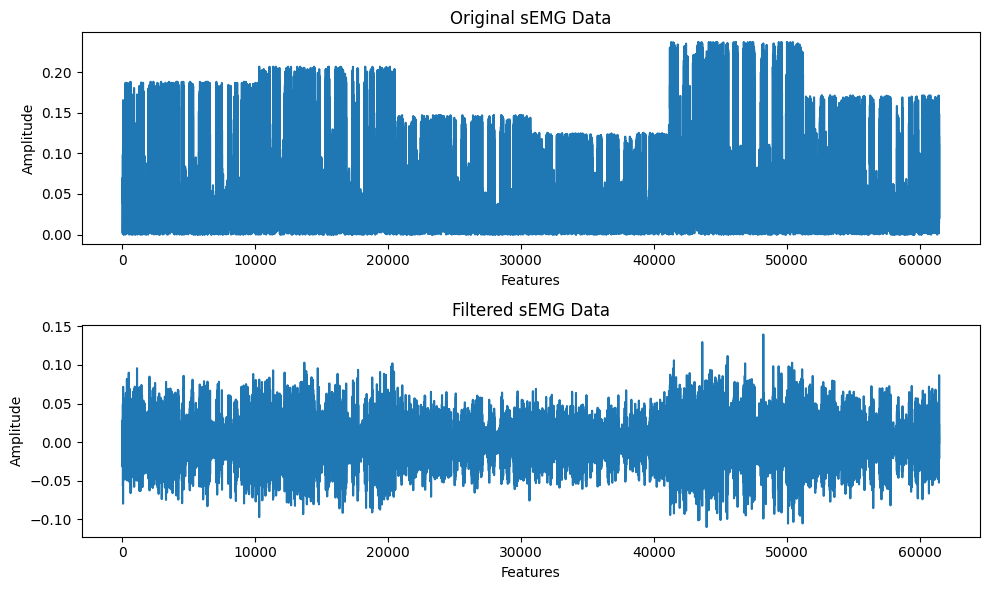

[0]


In [7]:
import matplotlib.pyplot as plt

# Plot original data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(rectified_semg_data[0])
plt.title('Original sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')

# Plot filtered data
plt.subplot(2, 1, 2)
plt.plot(filtered_data[0])
plt.title('Filtered sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

print(df_labels[0])


In [8]:
# Plot original data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(rectified_semg_data[2])
plt.title('Original sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')

# Plot filtered data
plt.subplot(2, 1, 2)
plt.plot(filtered_df.iloc[2,:])
plt.title('Filtered sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


print(df_labels[1])


KeyboardInterrupt: 

In [19]:
display(filtered_df)
print(len(filtered_df.iloc[0,:]))

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,-0.000893,0.015581,0.021259,0.016140,0.009982,0.010848,0.016119,0.015518,0.002514,-0.017804,...,0.002041,0.023522,0.017019,-0.009363,-0.021148,0.005465,0.055794,0.086725,0.065221,-0.000638
1,-0.000077,-0.021446,-0.025936,-0.013371,0.001203,0.004318,-0.003504,-0.012211,-0.014994,-0.012685,...,-0.006089,-0.011633,-0.012506,-0.008660,-0.002221,0.004777,0.010430,0.012140,0.007907,-0.000991
2,0.000202,-0.010373,-0.020321,-0.026586,-0.026031,-0.019776,-0.013004,-0.009383,-0.006859,-0.000434,...,-0.000172,0.014634,0.020764,0.011909,-0.002918,-0.006079,0.008558,0.025725,0.024212,0.001750
3,-0.000144,0.001563,0.000020,-0.003916,-0.006249,-0.004653,-0.001180,0.000243,-0.001776,-0.004991,...,0.011472,0.003898,-0.004382,-0.005980,0.000578,0.009172,0.012687,0.009969,0.005066,0.000962
4,0.000195,-0.010294,-0.002524,0.023470,0.050145,0.059860,0.049415,0.028539,0.007957,-0.008731,...,-0.004529,-0.009088,-0.010285,-0.014577,-0.023347,-0.030296,-0.028642,-0.019081,-0.008167,0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,0.000201,-0.001585,-0.003874,-0.005894,-0.006435,-0.005668,-0.005246,-0.006320,-0.007964,-0.007810,...,-0.008971,-0.019570,-0.013747,0.008861,0.030315,0.032008,0.013414,-0.007438,-0.012073,0.000274
3209,0.000074,-0.005029,-0.005380,-0.001301,0.002364,0.001753,-0.001834,-0.003751,-0.001554,0.002195,...,-0.009897,-0.009420,-0.006994,-0.002216,0.001505,0.000998,-0.002942,-0.006450,-0.006448,-0.003207
3210,0.000087,0.002327,0.001130,-0.002491,-0.003801,0.000428,0.007937,0.012724,0.010758,0.003628,...,-0.015485,-0.014265,-0.003835,0.014520,0.030566,0.032385,0.018404,0.000789,-0.005940,-0.000018
3211,0.000357,0.000941,0.002847,0.005645,0.007199,0.005786,0.002258,-0.000266,0.000606,0.003774,...,-0.004303,-0.003212,0.000688,0.003000,0.002001,-0.000029,-0.000360,0.000709,0.000788,-0.000963


61440


### Feature Reduction

In [10]:
# Reference: https://github.com/hkcornwell/sEMG-signal-classification
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

#PCA Transform
pca = PCA(n_components=20).fit(rectified_semg_data.T)
df_pca = pca.components_.T

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df_pca[2])
plt.title('Original sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')



NameError: name 'rectified_semg_data' is not defined

Text(0, 0.5, 'Amplitude')

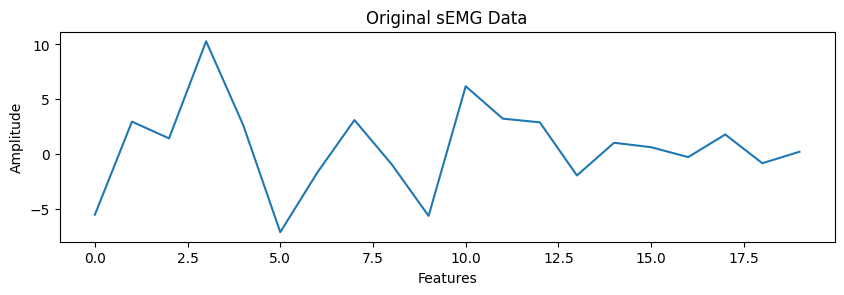

In [363]:

#Isomap Transform
iso = Isomap(n_components=20)
df_iso = iso.fit_transform(rectified_semg_data)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(df_iso[2])
plt.title('Original sEMG Data')
plt.xlabel('Features')
plt.ylabel('Amplitude')

## Classification

In [364]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC


import seaborn as sns

X = df_pca
# X = df_iso

y = df.iloc[:,-1:].values
y = np.ravel(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

### KNN

Accuracy: 0.19440124416796267


Text(0, 0.5, 'Accuracy Score')

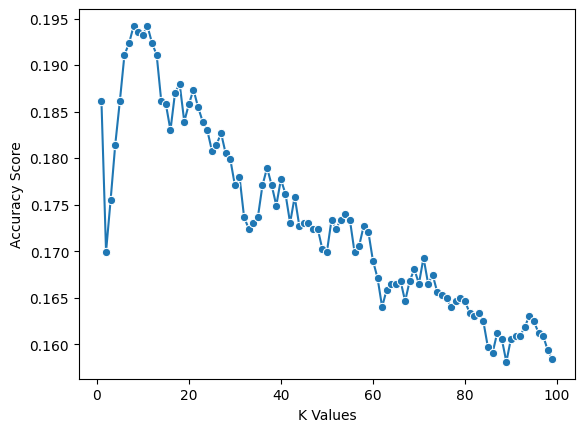

In [365]:
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=15))
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)




k_values = [i for i in range (1,100)]
scores = []

for k in k_values:
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))


sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

### SVC

Accuracy: 0.25972006220839816


Text(0, 0.5, 'Accuracy Score')

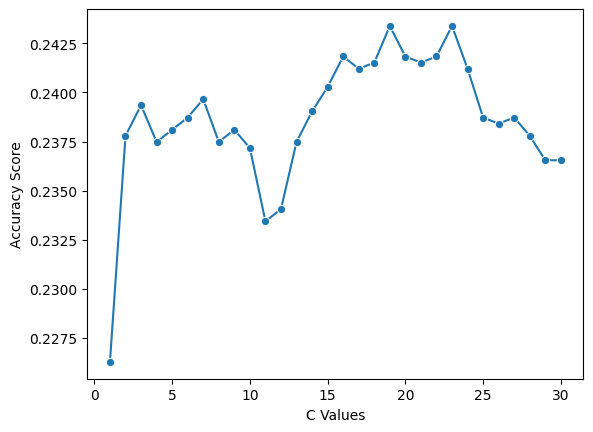

In [366]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto', C=10))
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


c_values = [i for i in range (1,31)]
scores = []
for c in c_values:
    knn = make_pipeline(StandardScaler(), SVC(C=c))
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))


sns.lineplot(x = c_values, y = scores, marker = 'o')
plt.xlabel("C Values")
plt.ylabel("Accuracy Score")